In [1]:
# %matplotlib widget

import os
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from astropy.table import Table

from copy import deepcopy as copy
from tqdm import tqdm
import bottleneck as bn

from lvmdrp import path, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp
from lvmdrp.functions import run_quickdrp as qdrp

from lvmdrp.core.tracemask import TraceMask
from lvmdrp.functions import imageMethod
from lvmdrp.functions import rssMethod

ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
MASTER_CON_LAMPS = {"b": "ldls", "r": "ldls", "z": "quartz"}
MASTER_ARC_LAMPS = {"b": "hgne", "r": "neon", "z": "neon"}
SLITMAP = Table(drp.fibermap.data)

In [2]:
MJD = 60255
# MJD = 60273
drp.get_frames_metadata(mjd=MJD, overwrite=False)

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2.dev0/1111/60255/raw_metadata.hdf5
[INFO]: Loading existing metadata store.
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2.dev0/1111/60255/raw_metadata.hdf5


[INFO]: found 1104 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2.dev0/1111/60255/raw_metadata.hdf5'
[INFO]: number of frames after filtering 1104
[INFO]: total number of frames found 1104


,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,xenon,argon,ldls,quartz,quality,qual,stage,status,drpqual,name
0,s,1111,60255,60254,flat,sp1,z1,7230,2.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z1-00007230.fits
1,s,1111,60255,60255,flat,sp2,r2,7277,50.0,True,...,True,True,False,False,excellent,0,1,0,0,sdR-s-r2-00007277.fits
2,s,1111,60255,60255,flat,sp2,z2,7307,50.0,True,...,True,True,False,False,excellent,0,1,0,0,sdR-s-z2-00007307.fits
3,s,1111,60255,60255,flat,sp2,z2,7321,50.0,True,...,True,True,False,False,excellent,0,1,0,0,sdR-s-z2-00007321.fits
4,s,1111,60255,60255,flat,sp2,b2,7351,1.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b2-00007351.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,s,1111,60255,60255,flat,sp3,r3,7276,10.0,True,...,True,True,False,False,excellent,0,1,0,0,sdR-s-r3-00007276.fits
1100,s,1111,60255,60255,flat,sp2,r2,7259,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-r2-00007259.fits
1101,s,1111,60255,60254,flat,sp3,z3,7231,3.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z3-00007231.fits
1102,s,1111,60255,60255,flat,sp2,z2,7282,10.0,True,...,True,True,False,False,excellent,0,1,0,0,sdR-s-z2-00007282.fits


In [3]:
expnums = range(8209, 8232+1)
expnums = range(7252, 7263+1)

flats_table = md.get_metadata(tileid="*", mjd=MJD, imagetyp="flat")
flats_table = flats_table.loc[flats_table.expnum.isin(expnums)]
flats_table

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2.dev0/1111/60255/raw_metadata.hdf5
[INFO]: found 1104 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2.dev0/1111/60255/raw_metadata.hdf5'
[INFO]: filtering by imagetyp = 'flat'
[INFO]: number of frames after filtering 801
[INFO]: total number of frames found 801


,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,xenon,argon,ldls,quartz,quality,qual,stage,status,drpqual,name
5,s,1111,60255,60255,flat,sp2,z2,7258,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-z2-00007258.fits
25,s,1111,60255,60255,flat,sp3,z3,7261,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-z3-00007261.fits
26,s,1111,60255,60255,flat,sp3,b3,7257,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-b3-00007257.fits
56,s,1111,60255,60255,flat,sp2,z2,7253,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-z2-00007253.fits
60,s,1111,60255,60255,flat,sp3,r3,7257,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-r3-00007257.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,s,1111,60255,60255,flat,sp3,b3,7254,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-b3-00007254.fits
782,s,1111,60255,60255,flat,sp2,b2,7256,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-b2-00007256.fits
787,s,1111,60255,60255,flat,sp1,r1,7260,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-r1-00007260.fits
788,s,1111,60255,60255,flat,sp2,b2,7254,10.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-b2-00007254.fits


In [4]:
masters_mjd = qdrp.get_master_mjd(MJD)
masters_path = os.path.join(ORIG_MASTER_DIR, f"{masters_mjd}")
print(f"Using master calibrations from {masters_path}")

Using master calibrations from /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/sandbox/calib/60255


In [5]:
flat_analogs = flats_table.groupby(["camera"])

mflat_paths = []
for camera in flat_analogs.groups:
    flats = flat_analogs.get_group(camera)
    flat = flats.iloc[0].to_dict()

    print(flats.sort_values("expnum").to_string())

    # define master paths for target frames
    mpixmask_path = os.path.join(masters_path, f"lvm-mpixmask-{camera}.fits")
    mbias_path = os.path.join(masters_path, f"lvm-mbias-{camera}.fits")
    mdark_path = os.path.join(masters_path, f"lvm-mdark-{camera}.fits")

    # preprocess and detrend flats
    for flat in flats.to_dict("records"):
        flat_path = path.full("lvm_raw", camspec=flat["camera"], **flat)
        pflat_path = path.full("lvm_anc", drpver=drpver, kind="p", imagetype=flat["imagetyp"], **flat)
        dflat_path = path.full("lvm_anc", drpver=drpver, kind="d", imagetype=flat["imagetyp"], **flat)
        os.makedirs(os.path.dirname(dflat_path), exist_ok=True)

        if os.path.isfile(dflat_path):
            print(f"skipping {dflat_path}, file already exist")
        else:
            imageMethod.preproc_raw_frame(in_image=flat_path, out_image=pflat_path, in_mask=mpixmask_path)
            imageMethod.detrend_frame(in_image=pflat_path, out_image=dflat_path, in_bias=mbias_path, in_dark=mdark_path, in_slitmap=SLITMAP)

    hemi  tileid    mjd   rmjd imagetyp spec camera  expnum  exptime   neon   hgne  krypton  xenon  argon   ldls  quartz    quality  qual  stage  status  drpqual                    name
237    s    1111  60255  60255     flat  sp1     b1    7252     10.0  False  False    False  False  False  False    True  excellent     0      1       0        0  sdR-s-b1-00007252.fits
111    s    1111  60255  60255     flat  sp1     b1    7253     10.0  False  False    False  False  False  False    True  excellent     0      1       0        0  sdR-s-b1-00007253.fits
603    s    1111  60255  60255     flat  sp1     b1    7254     10.0  False  False    False  False  False  False    True  excellent     0      1       0        0  sdR-s-b1-00007254.fits
592    s    1111  60255  60255     flat  sp1     b1    7255     10.0  False  False    False  False  False  False    True  excellent     0      1       0        0  sdR-s-b1-00007255.fits
420    s    1111  60255  60255     flat  sp1     b1    7256     10.0  

In [6]:
def _get_ring_expnums(expnums_ldls, expnums_qrtz, ring_size=12, sort_expnums=True):
    """Split expnums into primary and secondary ring expnums

    Given a set of MJDs and (optionally) exposure numbers, split the expnums
    into primary and secondary ring expnums. This routine will return the
    primary and secondary ring expnums for the given expnums.

    Parameters:
    ----------
    expnums_ldls : list
        List of LDLS expnums
    expnums_qrtz : list
        List of quartz expnums
    ring_size : int
        Size of the primary ring
    sort_expnums : bool
        Sort expnums

    Returns:
    -------
    expnum_params : dict
        Dictionary with the expnums parameters
    """

    # sort expnums
    if sort_expnums:
        expnums_ldls = sorted(expnums_ldls)
        expnums_qrtz = sorted(expnums_qrtz)

    # split expnums into primary and secondary ring expnums
    pri_ldls_expnums = expnums_ldls[:ring_size]
    pri_qrtz_expnums = expnums_qrtz[:ring_size]
    sec_ldls_expnums = expnums_ldls[ring_size:]
    sec_qrtz_expnums = expnums_qrtz[ring_size:]

    # define expnum parameters
    expnum_params = {camera: [] for camera in ["b1", "b2", "b3", "r1", "r2", "r3", "z1", "z2", "z3"]}
    for ring, ring_expnums in enumerate([(pri_ldls_expnums, pri_qrtz_expnums), (sec_ldls_expnums, sec_qrtz_expnums)]):
        for channel, expnums in [("b", ring_expnums[0]), ("r", ring_expnums[0]), ("z", ring_expnums[1])]:
            for fiber, expnum in enumerate(expnums):
                # define fiber ID
                fiber_str = f"P{ring+1}-{fiber+1}"
                # get spectrograph where current fiber is plugged
                fiber_par = SLITMAP[SLITMAP["orig_ifulabel"] == fiber_str]
                block_id = int(fiber_par["blockid"][0][1:])-1
                specid = fiber_par["spectrographid"][0]
                # define camera exposure
                camera = f"{channel}{specid}"

                # define exposure parameters
                expnum_params[camera].append((expnum, [block_id], fiber_str))

    # add missing blocks for first exposure
    for camera in expnum_params:
        expnums, block_ids, fiber_strs = zip(*expnum_params[camera])
        block_ids = list(zip(*block_ids))[0]
        missing_block_ids = list(set(range(18)) - set(block_ids))
        filled_block_ids = list(block_ids)[0:1] + missing_block_ids
        expnum_params[camera][0] = (expnums[0], filled_block_ids, fiber_strs[0])

    return expnum_params

In [7]:
pri_ldls_expnums = np.arange(8221, 8232+1)
sec_ldls_expnums = []
pri_qrtz_expnums, sec_qrtz_expnums = np.arange(8209, 8220+1), []

pri_ldls_expnums = np.arange(7264, 7269+1)
sec_ldls_expnums = []
pri_qrtz_expnums, sec_qrtz_expnums = np.arange(7252, 7263+1), []

# # load current traces
mcents, mwidths = {}, {}
for _ in product("brz", "123"):
    camera = "".join(_)
    mcents[camera] = TraceMask()
    mcents[camera].createEmpty(data_dim=(648, 4086), poly_deg=4)
    mwidths[camera] = TraceMask()
    mwidths[camera].createEmpty(data_dim=(648, 4086), poly_deg=3)

# iterate through exposures with std fibers exposed
expnum_params = _get_ring_expnums(pri_ldls_expnums, pri_qrtz_expnums, ring_size=12)
for camera, expnums in expnum_params.items():
    for expnum, block_idxs, fiber_str in expnums:
        con_lamp = MASTER_CON_LAMPS[camera[0]]
        if con_lamp == "ldls":
            counts_threshold = 5000
        elif con_lamp == "quartz":
            counts_threshold = 10000

        # select fibers in current spectrograph
        fibermap = SLITMAP[SLITMAP["spectrographid"] == int(camera[1])]
        # select first std fiber
        fiber_1st = fibermap[fibermap["telescope"] == "Spec"]["orig_ifulabel"][0]
        # select illuminated std fiber
        select = fibermap["orig_ifulabel"] == fiber_str
        # select fiber index
        fiber_idx = np.where(select)[0][0]
        trace_all = fiber_str == fiber_1st

        # define paths
        dflat_path = path.full("lvm_anc", drpver=drpver, tileid=1111, mjd=MJD, kind="d", imagetype="flat", camera=camera, expnum=expnum)
        flux_path = path.full("lvm_anc", drpver=drpver, tileid=1111, mjd=MJD, kind="d", imagetype="flux", camera=camera, expnum=expnum)
        cent_path = path.full("lvm_anc", drpver=drpver, tileid=1111, mjd=MJD, kind="d", imagetype="cent", camera=camera, expnum=expnum)
        fwhm_path = path.full("lvm_anc", drpver=drpver, tileid=1111, mjd=MJD, kind="d", imagetype="fwhm", camera=camera, expnum=expnum)

        # select only the block with the std fiber illuminated
        # if tracing the first fiber, then add the blocks with no std fibers as well
        block_id = fibermap[fiber_idx]["blockid"]
        if not trace_all:
            block_idxs = [int(block_id[1:])-1]
        else:
            block_idxs = [block_idx for block_idx in range(18)]
        print(f"going to trace std fiber {fiber_str} in {camera} within {block_idxs = }")

        centroids, trace_cent_fit, trace_flux_fit, trace_fwhm_fit = imageMethod.trace_fibers(
            in_image=dflat_path,
            out_trace_amp=flux_path, out_trace_cent=cent_path, out_trace_fwhm=fwhm_path, out_trace_cent_guess=None,
            correct_ref=True, median_box=(1,10), coadd=20,
            counts_threshold=counts_threshold, max_diff=1.5, guess_fwhm=2.5, method="gauss",
            ncolumns=(140, 40), iblocks=block_idxs, fwhm_limits=(1.5, 4.5),
            fit_poly=True, poly_deg=(4, 4, 3), display_plots=False
        )

        # load traces
        cent_trace = TraceMask()
        cent_trace.loadFitsData(cent_path)
        fwhm_trace = TraceMask()
        fwhm_trace.loadFitsData(fwhm_path)
        print(f"{camera = }, {expnum = }, {fiber_str = :>6s}, fiber_idx = {fiber_idx:>3d}, FWHM = {trace_fwhm_fit._data[fiber_idx].mean():.2f}")

        # update master traces
        select_block = np.isin(fibermap["blockid"], [f"B{id+1}" for id in block_idxs])
        mwidths[camera]._coeffs[select_block] = fwhm_trace._coeffs[select_block]
        mwidths[camera]._data[select_block] = fwhm_trace._data[select_block]
        mcents[camera]._coeffs[select_block] = cent_trace._coeffs[select_block]
        mcents[camera]._data[select_block] = cent_trace._data[select_block]
        mwidths[camera]._mask[select_block] = False
        mcents[camera]._mask[select_block] = False
        # masking bad fibers
        bad_fibers = fibermap["fibstatus"] == 1
        mwidths[camera]._mask[bad_fibers] = True
        mcents[camera]._mask[bad_fibers] = True

    # save master traces
    mcents[camera].writeFitsData(os.path.join(masters_path, f"lvm-mtrace-{camera}.fits"))
    mwidths[camera].writeFitsData(os.path.join(masters_path, f"lvm-mwidth-{camera}.fits"))

[INFO]: using flat image lvm-dflat-b1-00007264.fits for tracing


going to trace std fiber P1-1 in b1 within block_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -3.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:35<00:00,  4.01column/s]
[INFO]: fitti

camera = 'b1', expnum = 7264, fiber_str =   P1-1, fiber_idx =   1, FWHM = 2.45
going to trace std fiber P1-4 in b1 within block_idxs = [6]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -3.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:34<00:00,  4.12column/s]
[INFO]: fitti

camera = 'b1', expnum = 7267, fiber_str =   P1-4, fiber_idx = 217, FWHM = 2.41
going to trace std fiber P1-3 in b2 within block_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -2.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:36<00:00,  3.83column/s]
[INFO]: fitti

camera = 'b2', expnum = 7266, fiber_str =   P1-3, fiber_idx =   1, FWHM = 2.74
going to trace std fiber P1-6 in b2 within block_idxs = [6]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -2.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:36<00:00,  3.88column/s]
[INFO]: fitti

camera = 'b2', expnum = 7269, fiber_str =   P1-6, fiber_idx = 217, FWHM = 2.54
going to trace std fiber P1-2 in b3 within block_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: -2.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:33<00:00,  4.25column/s]
[INFO]: fitti

camera = 'b3', expnum = 7265, fiber_str =   P1-2, fiber_idx =   1, FWHM = 2.55
going to trace std fiber P1-5 in b3 within block_idxs = [6]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: -2.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:32<00:00,  4.29column/s]
[INFO]: fitti

camera = 'b3', expnum = 7268, fiber_str =   P1-5, fiber_idx = 217, FWHM = 2.46
going to trace std fiber P1-1 in r1 within block_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -7.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:32<00:00,  4.31column/s]
[INFO]: fitti

camera = 'r1', expnum = 7264, fiber_str =   P1-1, fiber_idx =   1, FWHM = 2.32
going to trace std fiber P1-4 in r1 within block_idxs = [6]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -7.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:31<00:00,  4.45column/s]
[INFO]: fitti

camera = 'r1', expnum = 7267, fiber_str =   P1-4, fiber_idx = 217, FWHM = 2.28
going to trace std fiber P1-3 in r2 within block_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -3.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:30<00:00,  4.59column/s]
[INFO]: fitti

camera = 'r2', expnum = 7266, fiber_str =   P1-3, fiber_idx =   1, FWHM = 2.89
going to trace std fiber P1-6 in r2 within block_idxs = [6]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -3.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:33<00:00,  4.20column/s]
[INFO]: fitti

camera = 'r2', expnum = 7269, fiber_str =   P1-6, fiber_idx = 217, FWHM = 2.50
going to trace std fiber P1-2 in r3 within block_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: -3.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:31<00:00,  4.53column/s]
[INFO]: fitti

camera = 'r3', expnum = 7265, fiber_str =   P1-2, fiber_idx =   1, FWHM = 2.28
going to trace std fiber P1-5 in r3 within block_idxs = [6]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: -3.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:33<00:00,  4.21column/s]
[INFO]: fitti

camera = 'r3', expnum = 7268, fiber_str =   P1-5, fiber_idx = 217, FWHM = 2.30
going to trace std fiber P1-1 in z1 within block_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -2.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:40<00:00,  3.51column/s]
[INFO]: fitti

camera = 'z1', expnum = 7252, fiber_str =   P1-1, fiber_idx =   1, FWHM = 2.75
going to trace std fiber P1-4 in z1 within block_idxs = [6]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -2.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:35<00:00,  3.96column/s]
[INFO]: fitti

camera = 'z1', expnum = 7255, fiber_str =   P1-4, fiber_idx = 217, FWHM = 2.63
going to trace std fiber P1-7 in z1 within block_idxs = [11]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -2.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:36<00:00,  3.85column/s]
[INFO]: fitti

camera = 'z1', expnum = 7258, fiber_str =   P1-7, fiber_idx = 397, FWHM = 2.64
going to trace std fiber P1-10 in z1 within block_idxs = [17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -2.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:37<00:00,  3.73column/s]
[INFO]: fitti

camera = 'z1', expnum = 7261, fiber_str =  P1-10, fiber_idx = 613, FWHM = 2.65
going to trace std fiber P1-3 in z2 within block_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -3.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:34<00:00,  4.07column/s]
[INFO]: fitti

camera = 'z2', expnum = 7254, fiber_str =   P1-3, fiber_idx =   1, FWHM = 2.79
going to trace std fiber P1-6 in z2 within block_idxs = [6]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -3.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:33<00:00,  4.27column/s]
[INFO]: fitti

camera = 'z2', expnum = 7257, fiber_str =   P1-6, fiber_idx = 217, FWHM = 2.69
going to trace std fiber P1-9 in z2 within block_idxs = [11]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -3.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:33<00:00,  4.25column/s]
[INFO]: fitti

camera = 'z2', expnum = 7260, fiber_str =   P1-9, fiber_idx = 397, FWHM = 2.75
going to trace std fiber P1-12 in z2 within block_idxs = [17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -3.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:34<00:00,  4.11column/s]
[INFO]: fitti

camera = 'z2', expnum = 7263, fiber_str =  P1-12, fiber_idx = 613, FWHM = 3.01
going to trace std fiber P1-2 in z3 within block_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: -4.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:34<00:00,  4.12column/s]
[INFO]: fitti

camera = 'z3', expnum = 7253, fiber_str =   P1-2, fiber_idx =   1, FWHM = 3.12
going to trace std fiber P1-5 in z3 within block_idxs = [6]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: -4.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:36<00:00,  3.89column/s]
[INFO]: fitti

camera = 'z3', expnum = 7256, fiber_str =   P1-5, fiber_idx = 217, FWHM = 2.67
going to trace std fiber P1-8 in z3 within block_idxs = [11]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: -4.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:35<00:00,  3.93column/s]
[INFO]: fitti

camera = 'z3', expnum = 7259, fiber_str =   P1-8, fiber_idx = 397, FWHM = 2.63
going to trace std fiber P1-11 in z3 within block_idxs = [17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: -4.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:36<00:00,  3.89column/s]
[INFO]: fitti

camera = 'z3', expnum = 7262, fiber_str =  P1-11, fiber_idx = 613, FWHM = 2.97


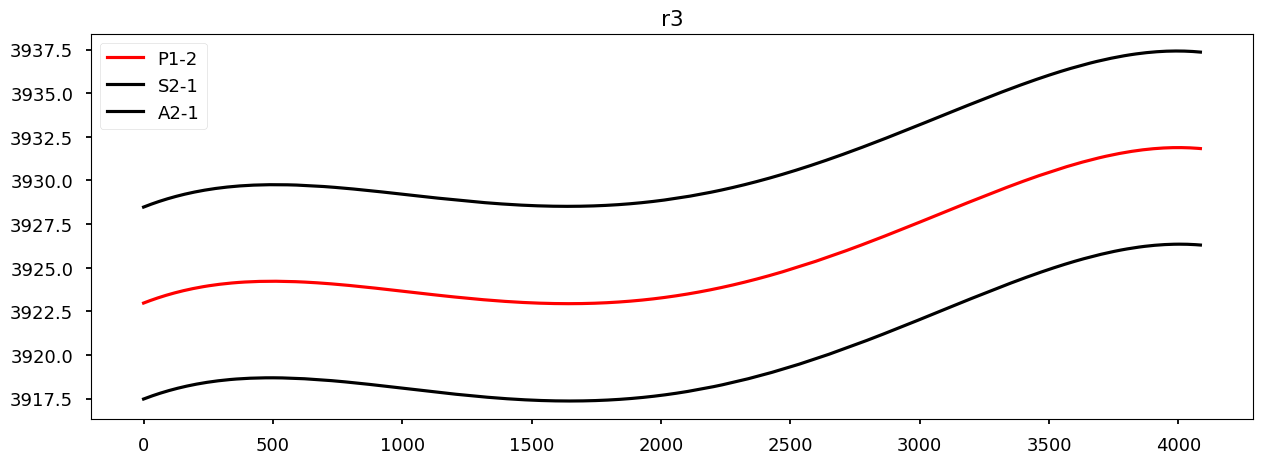

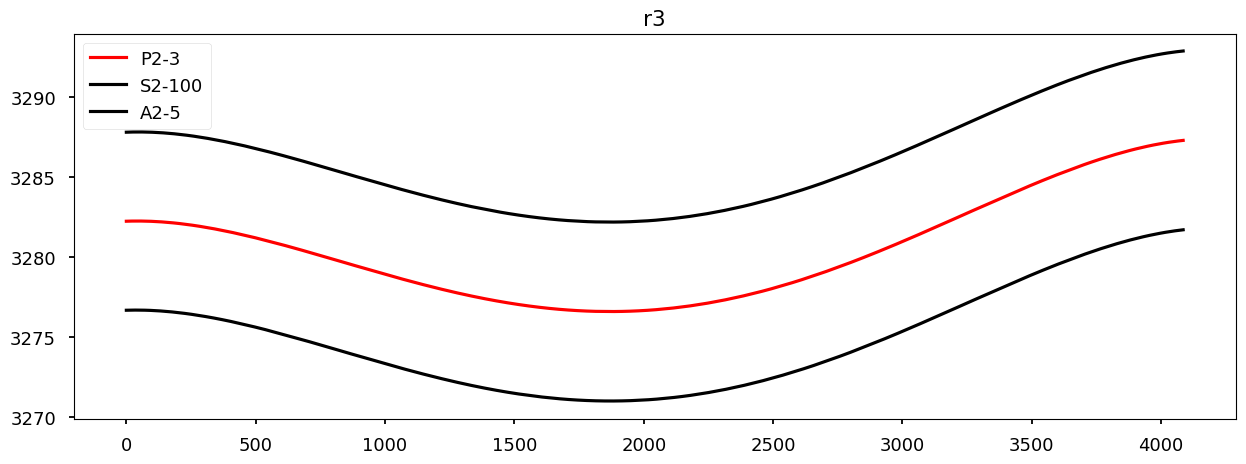

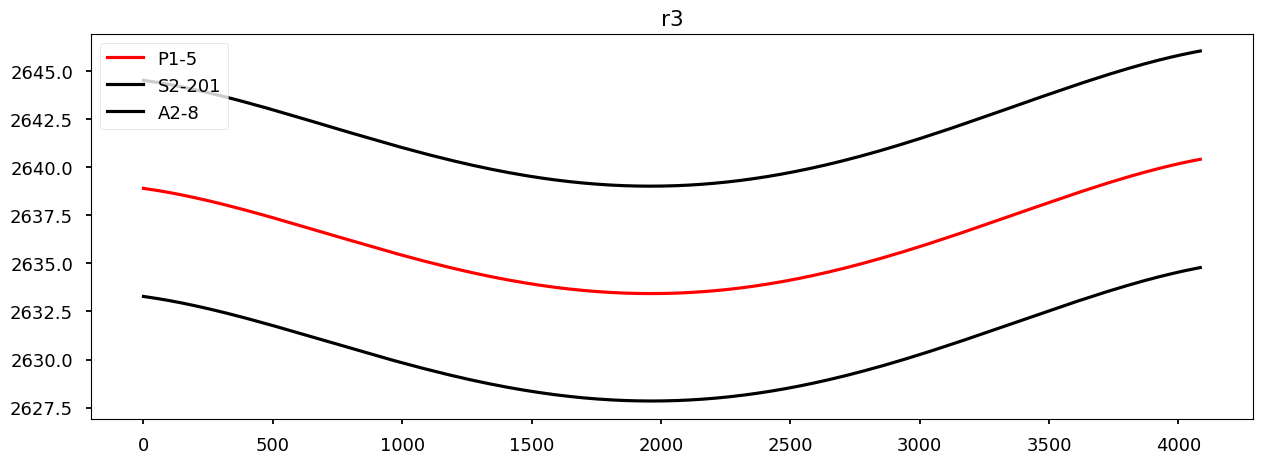

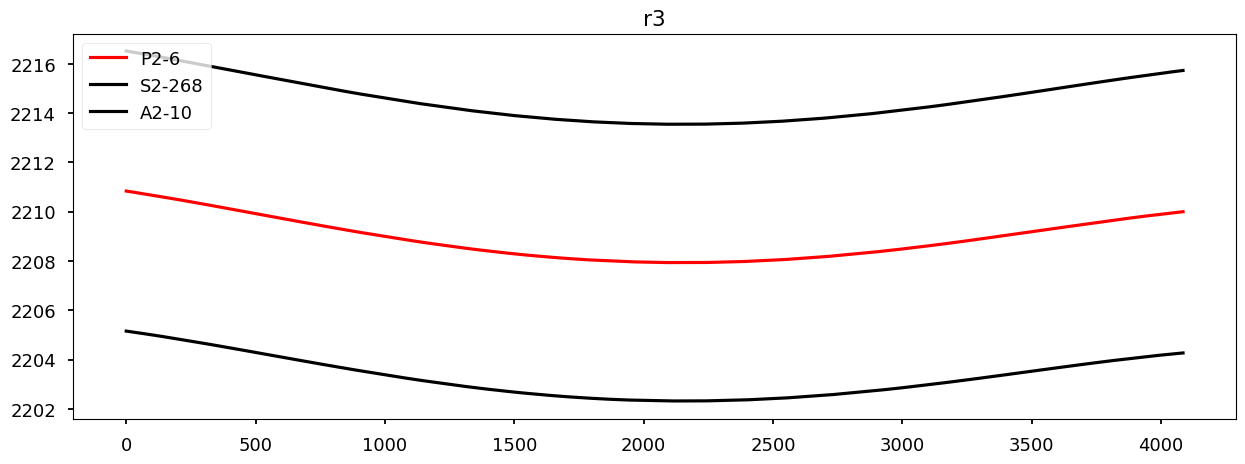

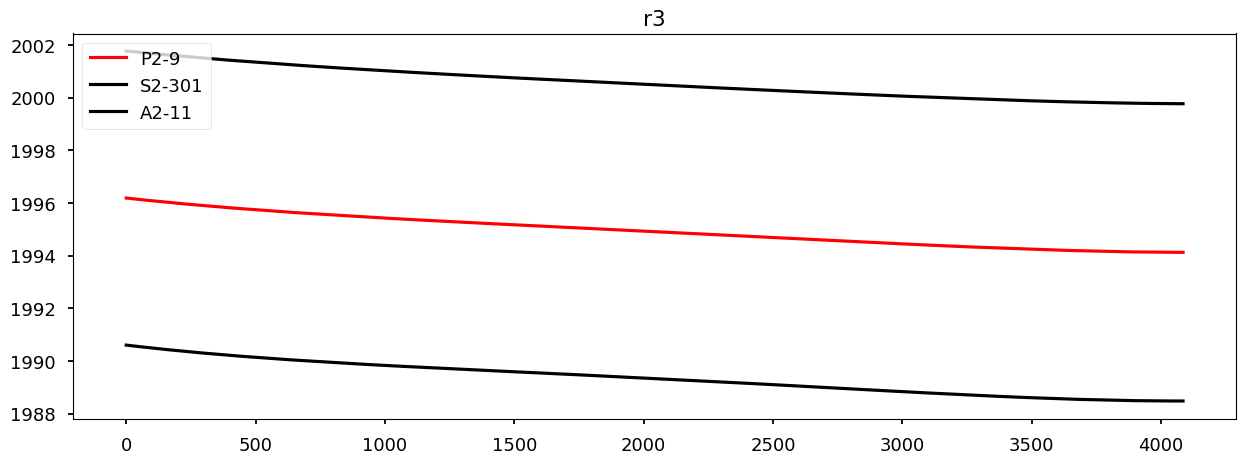

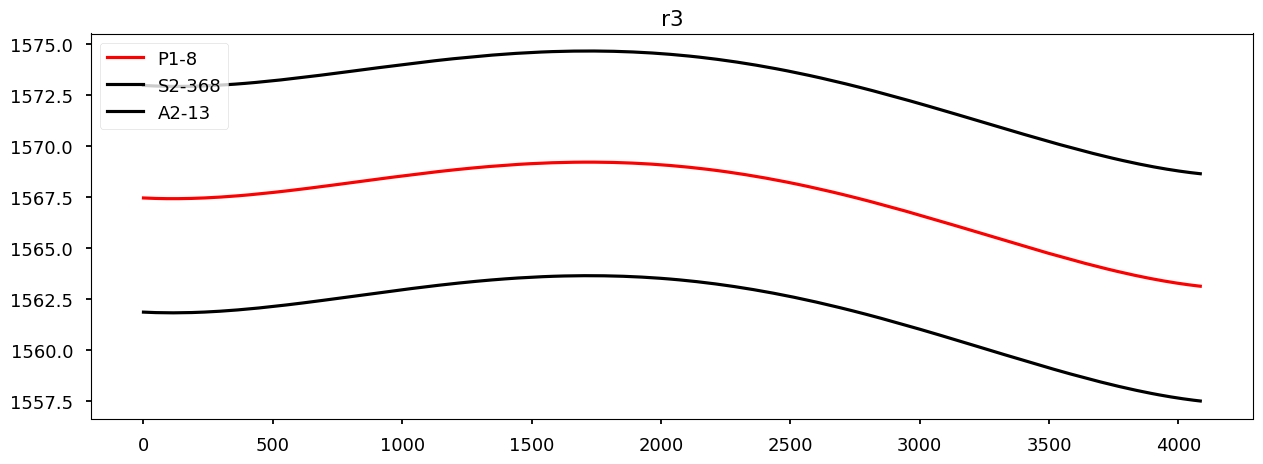

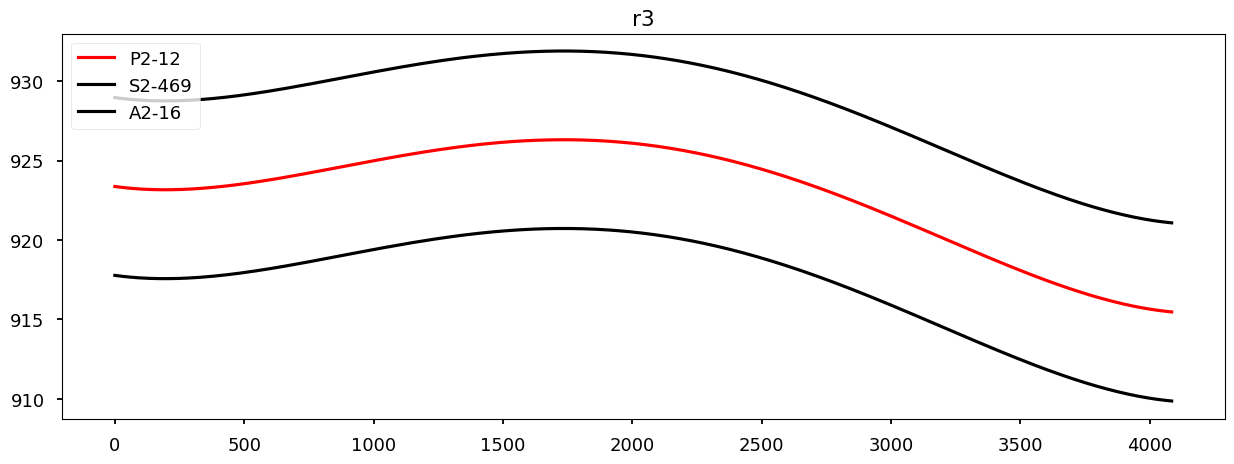

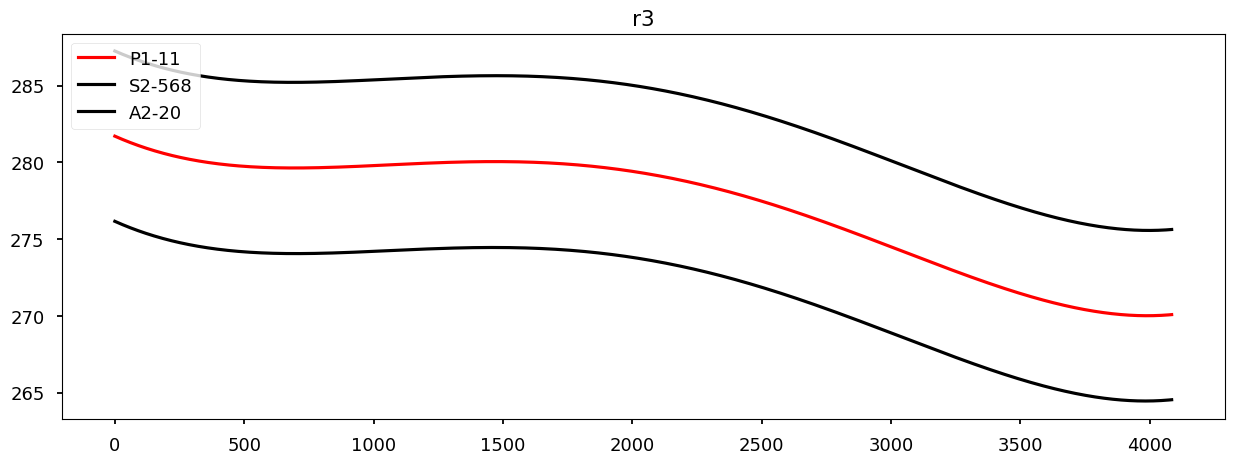

In [13]:
camera = "r3"
trace = copy(mcents[camera])

fibermap = SLITMAP[SLITMAP["spectrographid"] == int(camera[1])]
select = fibermap["telescope"] == "Spec"
con_lamp = MASTER_CON_LAMPS[camera[0]]

ifibers = np.where(select)[0]
for idx in ifibers:
    plt.figure(figsize=(15, 5))
    plt.plot(trace._data[idx], color="r", label=fibermap[idx]["orig_ifulabel"])
    plt.plot(trace._data[idx+1], color="k", label=fibermap[idx+1]["orig_ifulabel"])
    plt.plot(trace._data[idx-1], color="k", label=fibermap[idx-1]["orig_ifulabel"])
    plt.title(f"{camera}")
    plt.legend(loc=2)

In [9]:
# for camera in flat_analogs.groups:

#     con_lamp = MASTER_CON_LAMPS[camera[0]]
#     arc_lamp = MASTER_ARC_LAMPS[camera[0]]

#     mtrace_path = os.path.join(masters_path, f"lvm-mtrace-{camera}.fits")
#     mwidth_path = os.path.join(masters_path, f"lvm-mwidth-{camera}.fits")
#     mwave_path = os.path.join(masters_path, f"lvm-mwave_{arc_lamp}-{camera}.fits")
#     mlsf_path = os.path.join(masters_path, f"lvm-mlsf_{arc_lamp}-{camera}.fits")
#     # define master fiberflat path
#     mflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"mflat_{con_lamp}", camera=camera)
#     wflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{con_lamp}", camera=camera)

#     # if os.path.isfile(wflat_path):
#     #     print(f"skipping {wflat_path}, file already exist")
#     #     continue

#     # extract fiberflats
#     imageMethod.extract_spectra(in_image=mflat_path, out_rss=wflat_path, in_trace=mtrace_path, in_fwhm=mwidth_path, method="optimal", parallel=4)

#     # apply correction factor for the std fibers
#     fibermap = SLITMAP[SLITMAP["spectrographid"] == int(camera[1])]
#     select = fibermap["telescope"] == "Spec"
#     flat = rssMethod.loadRSS(wflat_path)
#     flat._data[select] = flat._data[select] * 24
#     flat._error[select] = flat._error[select] * 24
#     flat.writeFitsData(wflat_path)

#     rssMethod.create_pixel_table(in_rss=wflat_path, out_rss=wflat_path, arc_wave=mwave_path, arc_fwhm=mlsf_path)

In [10]:
# for camera in flat_analogs.groups.keys():
#     fibermap = SLITMAP[SLITMAP["spectrographid"] == int(camera[1])]
#     select = fibermap["telescope"] == "Spec"
#     con_lamp = MASTER_CON_LAMPS[camera[0]]

#     mtrace_path = os.path.join(masters_path, f"lvm-mtrace-{camera}.fits")
#     trace = TraceMask()
#     trace.loadFitsData(mtrace_path)
#     trace._data[select]

#     plt.figure(figsize=(10, 5))
#     idx = np.where(select)[0]
#     plt.plot(trace._data[idx][0], color="r")
#     plt.plot(trace._data[idx+1][0], color="k")
#     plt.plot(trace._data[idx-1][0], color="k")
#     plt.title(f"{camera}")

#     wflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{con_lamp}", camera=camera)
#     flat = rssMethod.loadRSS(wflat_path)
#     flat._data[flat._mask] = np.nan

#     plt.figure(figsize=(10, 5))
#     plt.plot(flat._wave[select].T, flat._data[select].T, label="std")
#     plt.title(f"{camera}")

In [11]:
# idx = 1

# flat = rssMethod.loadRSS(mfiberflat_paths[idx])
# print(mfiberflat_paths[idx])

# fibermap = SLITMAP[SLITMAP["spectrographid"] == 1]
# select = fibermap["telescope"] == "Spec"
# print(fibermap[select])
# plt.plot(flat._wave[~select][:12].T, flat._data[~select][:12].T)
# plt.plot(flat._wave[select].T, flat._data[select].T, "-k")